In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision.models import vgg16, vgg19
from torchvision import transforms
import glob
import numpy as np
from PIL import Image
from tqdm import tqdm
from collections import namedtuple
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

### Image Transformation Network
This is based on Justin C. Johnson's paper, [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf).
Here, we are going to make the proposed network for generating the end image (as in the convolutional neural network the will learn weights in order to efficiently calculate how to create an image based on a style)

### Architecture
![Architecture](./images/transformation-network-table.PNG)

In [51]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # For the transformation network, the authors only used 3x3 convolutions
        self.conv = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.out_channels,
                               kernel_size = 3)
        self.batch_norm = nn.InstanceNorm2d(self.out_channels, affine=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        # First convolution
        orig_x = x.clone()
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        
        # Second convolution
        x = self.conv(x)
        x = self.batch_norm(x)
        
        # Now add the original to the new one (and use center cropping)
        # Calulate the different between the size of each feature (in terms 
        # of height/width) to get the center of the original feature
        height_diff = orig_x.size()[2] - x.size()[2]
        width_diff = orig_x.size()[3] - x.size()[3]
        
        # Add the original to the new (complete the residual block)
        x = x + orig_x[:, :,
                                 height_diff//2:(orig_x.size()[2] - height_diff//2), 
                                 width_diff//2:(orig_x.size()[3] - width_diff//2)]
        
        return x

In [52]:
class ImageTransformationNetwork(nn.Module):
    def __init__(self):
        super(ImageTransformationNetwork, self).__init__()
        # Use reflection padding to keep the end shape
        self.ref_pad = nn.ReflectionPad2d(40)
        
        # Initial convolutions
        self.conv1 = nn.Conv2d(in_channels = 3,
                               out_channels = 32,
                               kernel_size = 9,
                               padding = 6,
                               padding_mode = 'reflect')
        
        self.conv2 = nn.Conv2d(in_channels = 32,
                               out_channels = 64,
                               kernel_size = 3,
                               stride = 2)
        
        self.conv3 = nn.Conv2d(in_channels = 64,
                               out_channels = 128,
                               kernel_size = 3,
                               stride = 2)
        
        # Residual Blocks
        self.resblock1 = ResidualBlock(in_channels = 128,
                                       out_channels = 128)
        
        self.resblock2 = ResidualBlock(in_channels = 128,
                                       out_channels = 128)
        
        self.resblock3 = ResidualBlock(in_channels = 128,
                                       out_channels = 128)
        
        self.resblock4 = ResidualBlock(in_channels = 128,
                                       out_channels = 128)
        
        self.resblock5 = ResidualBlock(in_channels = 128,
                                       out_channels = 128)
        
        # Transpose convoltutions
        self.trans_conv1 = nn.ConvTranspose2d(in_channels=128,
                                             out_channels=64,
                                             kernel_size=2,
                                             stride=2)
        
        self.trans_conv2 = nn.ConvTranspose2d(in_channels=64,
                                              out_channels=32,
                                              kernel_size=2,
                                              stride=2)
        
        # End with one last convolution
        self.conv4 = nn.Conv2d(in_channels = 32,
                               out_channels = 3,
                               kernel_size = 9,
                               padding = 4,
                               padding_mode = 'reflect')
        
    def forward(self, x):
        # Apply reflection padding
        x = self.ref_pad(x)
        
        # Apply the initial convolutions
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        # Apply the residual blocks
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.resblock5(x)        
        
        #  Apply the transpose convolutions
        x = self.trans_conv1(x)
        x = self.trans_conv2(x)
        
        # Apply the final convolution
        x = self.conv4(x)
        
        return x

In [5]:
# Test to confirm the residual network works
resblock = ResidualBlock(128, 128)
test = torch.randn(2, 128, 84, 84)
out = resblock(test)
print(out.size())

torch.Size([2, 128, 80, 80])


In [6]:
# Test to confirm the transormational network works
transformation_net = ImageTransformationNetwork()
test = torch.randn(2, 3, 256, 256)
out = transformation_net(test)
print(out.size())

torch.Size([2, 3, 256, 256])


### Cost Functions
Now we must implement the different cost functions

Style Relu Indices: 3, 8, 15, 22  
Content Relu Index: 15

In [10]:
class ForwardVGG19(torch.nn.Module):
    def __init__(self):
        super(ForwardVGG19, self).__init__()
        features = list(vgg19(pretrained=True).features)
        self.features = nn.ModuleList(features).eval()
        
    def forward(self, x, style):
        results = []
        for i, model in enumerate(self.features):
            x = model(x)
            if style:
                if i in {3, 8, 15, 22}:
                    results.append(x)
            
            else:
                if i == 15:
                    results.append(x)
        
        return results

forward_vgg = ForwardVGG19()

In [11]:
def normalize_batch(batch):
    """
    Before we send an image into the VGG16, we have to normalize it
    """
    vgg_means = [123.68, 116.779, 103.94]
    ret = torch.zeros(*batch.size())
    ret[:, 0, :, :] = batch[:, 0, :, :] - vgg_means[0]
    ret[:, 1, :, :] = batch[:, 1, :, :] - vgg_means[1]
    ret[:, 2, :, :] = batch[:, 2, :, :] - vgg_means[2]
    return ret

In [12]:
def denormalize_batch(batch):
    vgg_means = [123.68, 116.779, 103.94]
    ret = torch.zeros(*batch.size())
    ret[:, 0, :, :] = batch[:, 0, :, :] + vgg_means[0]
    ret[:, 1, :, :] = batch[:, 1, :, :] + vgg_means[1]
    ret[:, 2, :, :] = batch[:, 2, :, :] + vgg_means[2]
    return ret

In [32]:
def add_noise(batch):
    """
    For the input image, we have to add noise so that the loss between the content image and 
    input image is not 0
    """
    mean = 0.0
    std = 10.0
    ret = batch + np.random.normal(mean, std, batch.shape)
    ret = np.clip(batch, 0, 255)
    return ret

In [40]:
def compute_gram(matrix):
    """
    Computes the gram matrix
    """
    batches, channels, height, width = matrix.size()
    return (torch.matmul(matrix.view(batches, channels, -1),
            torch.transpose(matrix.view(batches, channels, -1), 1, 2)))


In [34]:
def compute_fro_norm(matrix):
    """
    Computes the frobenius norm
    """
    batches, height, width = matrix.size()
    return torch.norm(matrix.view(batches, 1, -1), 'fro', dim=2)

In [56]:
def content_cost(input, target):
    # First normalize both the input and target (preprocess for VGG16)
    input_norm = normalize_batch(input)
    target_norm = normalize_batch(target)

    input_layers = forward_vgg(input_norm, False)
    target_layers = forward_vgg(target_norm, False)

    accumulated_loss = 0
    for layer in range(len(input_layers)):
        batches, channels, height, width = input_layers[layer].size()
        accumulated_loss = accumulated_loss + (1/(channels * height * width)) * \
                            (torch.sum(torch.square(input_layers[layer] - target_layers[layer])))
    
    return accumulated_loss

In [59]:
def style_cost(input, target):
    # First normalize both the input and target (preprocess for VGG16)
    input_norm = normalize_batch(input)
    target_norm = normalize_batch(target)

    input_layers = forward_vgg(input_norm, True)
    target_layers = forward_vgg(target_norm, True)
    
    accumulated_loss = 0
    for layer in range(len(input_layers)):
        batches, channels, height, width = input_layers[layer].size()
        accumulated_loss = accumulated_loss + 0.25 * ((1/(4 * channels**2 * (height * width) ** 2)) * \
                            torch.sum(torch.square(compute_gram(input_layers[layer]) -
                                                    compute_gram(target_layers[layer]))))
    
    return accumulated_loss

In [45]:
def total_variation_cost(input):
    tvloss = (
        torch.sum(torch.abs(input[:, :, :, :-1] - input[:, :, :, 1:])) + 
        torch.sum(torch.abs(input[:, :, :-1, :] - input[:, :, 1:, :]))
    )
    return tvloss

In [46]:
def total_cost(input, targets):
    REG_TV = 1e-4
    REG_STYLE = 1e-4
    REG_CONTENT = 1e-6
    content, style = targets
    closs = content_cost(input, content)
    sloss = style_cost(input, style)
    tvloss = total_variation_cost(input)
    
    return REG_CONTENT * closs + REG_STYLE * sloss + REG_TV * tvloss
    

### Data Loading

In [47]:
# Constants
IMG_DIMENSIONS = (256, 256)
DATA = list(glob.iglob('data/content_images/*'))
STYLE_IMAGE = np.asarray(Image.open('data/style_image.png').resize(IMG_DIMENSIONS)).transpose(2, 0, 1)[0:3]

# Make the style image a batch and convert
STYLE_IMAGE = STYLE_IMAGE.reshape(1, 3, 256, 256)
MAX_TRAIN = 60000
MAX_VAL = 70000
TOTAL_DATA = len(DATA)

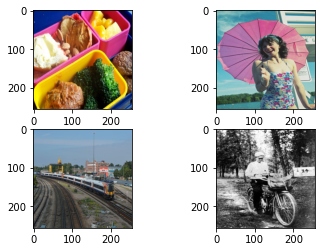

In [32]:
def show_sample_images():
    f, axarr = plt.subplots(2,2)
    
    # Show colored images
    axarr[0,0].imshow(np.asarray(Image.open(DATA[0]).resize(IMG_DIMENSIONS)))
    axarr[0,1].imshow(np.asarray(Image.open(DATA[4]).resize(IMG_DIMENSIONS)))
    axarr[1,0].imshow(np.asarray(Image.open(DATA[8]).resize(IMG_DIMENSIONS)))
    
    # Grayscale example
    grayscale = np.asarray(Image.open(DATA[13]).resize(IMG_DIMENSIONS))
    grayscale = np.stack((grayscale, grayscale, grayscale)).transpose(1, 2, 0)
    axarr[1,1].imshow(grayscale)
    
show_sample_images()

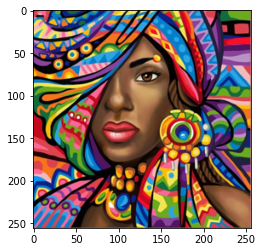

In [36]:
# Show the chosen style image
plt.imshow(STYLE_IMAGE[0].transpose(1, 2, 0))

In [48]:
def load_training_batch(current_batch, batch_size, set_type):
    """
    Load different batches of data (essentially a custom data loader for training, validation, and testing)
    """
    # The initial position is where we want to start getting the batch
    # So it is the starting index of the batch
    initial_pos = current_batch * batch_size
    
    # List to store the images
    images = []
    
    # Make sure the batch is within the [0, MAX_TRAIN]
    if set_type == 'train':
        if initial_pos + batch_size > MAX_TRAIN:
            batch_size = MAX_TRAIN - initial_pos
    
    # Make sure the batch is within the [MAX_TRAIN, MAX_VAL]
    elif set_type == 'val':
        initial_pos = MAX_TRAIN + initial_pos
        if initial_pos + batch_size > MAX_VAL:
            batch_size = MAX_VAL - initial_pos
    
    # Make sure the batch is within the [MAX_VAL, TOTAL_DATA]
    elif set_type == 'test':
        initial_pos = MAX_VAL + initial_pos
        if initial_pos + batch_size > TOTAL_DATA:
            batch_size = TOTAL_DATA - initial_pos

    for f in DATA[initial_pos:initial_pos + batch_size]:
        # Resize the image to 256 x 256
        image = np.asarray(Image.open(f).resize(IMG_DIMENSIONS))
        
        # If the image is grayscale, stack the image 3 times to get 3 channels
        if image.shape == IMG_DIMENSIONS:
            image = np.stack((image, image, image))
            images.append(image)
            continue
            
        # Transpose the image to have channels first
        image = image.transpose(2, 0, 1)
        images.append(image)
    
    return np.array(images)

### Training

In [61]:
BATCH_SIZE = 4
STYLE_IMAGE_TENSOR = torch.from_numpy(np.copy(STYLE_IMAGE)).float()
transformation_net = ImageTransformationNetwork()
opt = optim.Adam(transformation_net.parameters(), lr=1e-3)

In [62]:
for epoch in range(2):
    transformation_net.train()
    for batch, _ in enumerate(range(0, MAX_TRAIN, BATCH_SIZE)):
        # The content batch is the same as the train batch, except train batch has noise added to it
        train_batch = load_training_batch(batch, BATCH_SIZE, 'train')
        content_batch = np.copy(train_batch)
        
        # Add noise to the training batch
        train_batch = add_noise(train_batch)

        # Convert the batches to tensors
        train_batch = torch.from_numpy(train_batch).float()
        content_batch = torch.from_numpy(content_batch).float()

        # Zero the gradients
        opt.zero_grad()

        # Forward propagate
        gen_images = transformation_net(train_batch)

        # Compute loss
        loss = total_cost(gen_images, [content_batch, STYLE_IMAGE_TENSOR])

        # Backprop
        loss.backward()
        
        # Clip the gradient to minimize chance of exploding gradients
        torch.nn.utils.clip_grad_norm_(transformation_net.parameters(), 1.0)
        
        # Apply gradients
        opt.step()

        print("Training Batch: {}".format(batch + 1), "Loss: {:f}".format(loss))
    
    transformation_net.eval()
    
    for batch, _ in enumerate(range(MAX_TRAIN, MAX_VAL, BATCH_SIZE)):
        # The content batch is the same as the train batch, except train batch has noise added to it
        val_batch = load_training_batch(batch, BATCH_SIZE, 'val')
        content_batch = np.copy(train_batch)
        
        # Add noise to the training batch
        val_batch = add_noise(train_batch)
        
        print(type(val_batch))
        
        # Convert the batches to tensors
        val_batch = torch.from_numpy(val_batch).float()
        content_batch = torch.from_numpy(content_batch).float()
        
        # Forward propagate
        gen_images = transformation_net(val_batch)

        # Compute loss
        loss = total_cost(gen_images, [content_batch, STYLE_IMAGE_TENSOR])
        
        print("Validation Batch: {}".format(batch + 1), "Loss: {:f}".format(loss))
    
    

Training Batch: 1 Loss: 83167.976562
Training Batch: 2 Loss: 125113.414062
Training Batch: 3 Loss: 84784.843750
Training Batch: 4 Loss: 80304.585938
Training Batch: 5 Loss: 75063.023438
Training Batch: 6 Loss: 71595.398438
Training Batch: 7 Loss: 70728.867188
Training Batch: 8 Loss: 70079.585938
Training Batch: 9 Loss: 68456.296875
Training Batch: 10 Loss: 67481.351562
Training Batch: 11 Loss: 70713.335938
Training Batch: 12 Loss: 65309.132812
Training Batch: 13 Loss: 65071.726562
Training Batch: 14 Loss: 61480.417969
Training Batch: 15 Loss: 61810.789062
Training Batch: 16 Loss: 57208.648438
Training Batch: 17 Loss: 54161.425781
Training Batch: 18 Loss: 55570.195312
Training Batch: 19 Loss: 65274.464844
Training Batch: 20 Loss: 59635.585938
Training Batch: 21 Loss: 69862.718750
Training Batch: 22 Loss: 50458.648438
Training Batch: 23 Loss: 49156.863281
Training Batch: 24 Loss: 90249.640625
Training Batch: 25 Loss: 205310.031250
Training Batch: 26 Loss: 155763.265625
Training Batch: 27

Training Batch: 214 Loss: 19846.921875
Training Batch: 215 Loss: 16910.283203
Training Batch: 216 Loss: 18280.689453
Training Batch: 217 Loss: 19032.390625
Training Batch: 218 Loss: 19030.367188
Training Batch: 219 Loss: 16979.292969
Training Batch: 220 Loss: 19649.361328
Training Batch: 221 Loss: 18800.791016
Training Batch: 222 Loss: 17756.318359
Training Batch: 223 Loss: 17571.841797
Training Batch: 224 Loss: 18646.378906
Training Batch: 225 Loss: 17693.294922
Training Batch: 226 Loss: 16325.750977
Training Batch: 227 Loss: 17602.333984
Training Batch: 228 Loss: 18130.218750
Training Batch: 229 Loss: 17946.226562
Training Batch: 230 Loss: 17343.978516
Training Batch: 231 Loss: 17977.589844
Training Batch: 232 Loss: 19068.906250
Training Batch: 233 Loss: 17080.226562
Training Batch: 234 Loss: 16830.302734
Training Batch: 235 Loss: 17521.734375
Training Batch: 236 Loss: 17638.019531
Training Batch: 237 Loss: 17239.162109
Training Batch: 238 Loss: 18060.537109
Training Batch: 239 Loss:

Training Batch: 425 Loss: 12572.795898
Training Batch: 426 Loss: 12241.214844
Training Batch: 427 Loss: 11624.326172
Training Batch: 428 Loss: 11618.843750
Training Batch: 429 Loss: 13004.210938
Training Batch: 430 Loss: 11949.598633
Training Batch: 431 Loss: 12311.925781
Training Batch: 432 Loss: 12025.862305
Training Batch: 433 Loss: 12675.382812
Training Batch: 434 Loss: 15639.332031
Training Batch: 435 Loss: 14360.468750
Training Batch: 436 Loss: 13452.116211
Training Batch: 437 Loss: 11948.495117
Training Batch: 438 Loss: 13681.423828
Training Batch: 439 Loss: 13082.965820
Training Batch: 440 Loss: 12674.316406
Training Batch: 441 Loss: 11808.776367
Training Batch: 442 Loss: 17048.033203
Training Batch: 443 Loss: 14540.365234
Training Batch: 444 Loss: 13063.589844
Training Batch: 445 Loss: 12712.094727
Training Batch: 446 Loss: 17182.513672
Training Batch: 447 Loss: 14006.226562
Training Batch: 448 Loss: 12561.361328
Training Batch: 449 Loss: 12497.734375
Training Batch: 450 Loss:

Training Batch: 637 Loss: 10958.541992
Training Batch: 638 Loss: 10000.432617
Training Batch: 639 Loss: 11298.005859
Training Batch: 640 Loss: 10125.518555
Training Batch: 641 Loss: 9277.552734
Training Batch: 642 Loss: 9795.606445
Training Batch: 643 Loss: 9514.319336
Training Batch: 644 Loss: 9119.128906
Training Batch: 645 Loss: 10929.671875
Training Batch: 646 Loss: 10456.438477
Training Batch: 647 Loss: 10553.073242
Training Batch: 648 Loss: 9441.354492
Training Batch: 649 Loss: 9666.181641
Training Batch: 650 Loss: 10108.733398
Training Batch: 651 Loss: 9993.035156
Training Batch: 652 Loss: 12415.273438
Training Batch: 653 Loss: 10942.192383
Training Batch: 654 Loss: 12296.263672
Training Batch: 655 Loss: 12131.839844
Training Batch: 656 Loss: 10049.121094
Training Batch: 657 Loss: 10717.127930
Training Batch: 658 Loss: 10763.070312
Training Batch: 659 Loss: 9572.491211
Training Batch: 660 Loss: 11390.413086
Training Batch: 661 Loss: 8947.854492
Training Batch: 662 Loss: 9856.386

Training Batch: 852 Loss: 7399.350586
Training Batch: 853 Loss: 7400.203125
Training Batch: 854 Loss: 7204.666016
Training Batch: 855 Loss: 6967.076660
Training Batch: 856 Loss: 7406.768066
Training Batch: 857 Loss: 7063.266602
Training Batch: 858 Loss: 7506.318848
Training Batch: 859 Loss: 7802.627930
Training Batch: 860 Loss: 7936.767578
Training Batch: 861 Loss: 7680.276855
Training Batch: 862 Loss: 6967.658691
Training Batch: 863 Loss: 7358.038574
Training Batch: 864 Loss: 8080.353516
Training Batch: 865 Loss: 7772.997070
Training Batch: 866 Loss: 7028.161133
Training Batch: 867 Loss: 7869.655273
Training Batch: 868 Loss: 7905.380371
Training Batch: 869 Loss: 8519.705078
Training Batch: 870 Loss: 7560.669922
Training Batch: 871 Loss: 8053.786621
Training Batch: 872 Loss: 9401.875000
Training Batch: 873 Loss: 8918.733398
Training Batch: 874 Loss: 8263.891602
Training Batch: 875 Loss: 7806.546875
Training Batch: 876 Loss: 8389.804688
Training Batch: 877 Loss: 8442.417969
Training Bat

Training Batch: 1066 Loss: 6897.172852
Training Batch: 1067 Loss: 6819.812988
Training Batch: 1068 Loss: 7273.255371
Training Batch: 1069 Loss: 7998.104980
Training Batch: 1070 Loss: 8596.992188
Training Batch: 1071 Loss: 7392.338867
Training Batch: 1072 Loss: 6326.828125
Training Batch: 1073 Loss: 6930.492188
Training Batch: 1074 Loss: 7121.736328
Training Batch: 1075 Loss: 7344.207031
Training Batch: 1076 Loss: 6551.915039
Training Batch: 1077 Loss: 7343.828125
Training Batch: 1078 Loss: 7984.958008
Training Batch: 1079 Loss: 7591.769531
Training Batch: 1080 Loss: 7004.926758
Training Batch: 1081 Loss: 7016.843750
Training Batch: 1082 Loss: 6980.438965
Training Batch: 1083 Loss: 6704.379883
Training Batch: 1084 Loss: 8911.633789
Training Batch: 1085 Loss: 13079.071289
Training Batch: 1086 Loss: 10077.832031
Training Batch: 1087 Loss: 9227.778320
Training Batch: 1088 Loss: 9752.085938
Training Batch: 1089 Loss: 8304.218750
Training Batch: 1090 Loss: 7051.985840
Training Batch: 1091 Lo

Training Batch: 1277 Loss: 6162.912109
Training Batch: 1278 Loss: 6344.318359
Training Batch: 1279 Loss: 6460.018555
Training Batch: 1280 Loss: 6459.925293
Training Batch: 1281 Loss: 6200.167969
Training Batch: 1282 Loss: 6125.923828
Training Batch: 1283 Loss: 6168.305664
Training Batch: 1284 Loss: 6845.619141
Training Batch: 1285 Loss: 6265.486328
Training Batch: 1286 Loss: 8279.842773
Training Batch: 1287 Loss: 7087.650879
Training Batch: 1288 Loss: 6341.804688
Training Batch: 1289 Loss: 6494.569824
Training Batch: 1290 Loss: 6455.819336
Training Batch: 1291 Loss: 7037.584961
Training Batch: 1292 Loss: 6898.056641
Training Batch: 1293 Loss: 6362.842773
Training Batch: 1294 Loss: 6870.857422
Training Batch: 1295 Loss: 6300.645508
Training Batch: 1296 Loss: 6805.154785
Training Batch: 1297 Loss: 6669.896484
Training Batch: 1298 Loss: 6512.989746
Training Batch: 1299 Loss: 6510.625000
Training Batch: 1300 Loss: 6993.900391
Training Batch: 1301 Loss: 6345.132812
Training Batch: 1302 Loss

Training Batch: 1488 Loss: 6225.512695
Training Batch: 1489 Loss: 6181.482422
Training Batch: 1490 Loss: 6251.123047
Training Batch: 1491 Loss: 6488.816406
Training Batch: 1492 Loss: 5998.898438
Training Batch: 1493 Loss: 5848.218750
Training Batch: 1494 Loss: 5798.410156
Training Batch: 1495 Loss: 5637.679199
Training Batch: 1496 Loss: 5782.417969
Training Batch: 1497 Loss: 5736.123047
Training Batch: 1498 Loss: 5545.876953
Training Batch: 1499 Loss: 5835.800781
Training Batch: 1500 Loss: 5892.384277
Training Batch: 1501 Loss: 5679.796875
Training Batch: 1502 Loss: 6108.770508
Training Batch: 1503 Loss: 6674.793945
Training Batch: 1504 Loss: 6336.397949
Training Batch: 1505 Loss: 6310.124023
Training Batch: 1506 Loss: 6101.125000
Training Batch: 1507 Loss: 6085.853027
Training Batch: 1508 Loss: 5741.362793
Training Batch: 1509 Loss: 5805.473145
Training Batch: 1510 Loss: 6140.274414
Training Batch: 1511 Loss: 6286.101562
Training Batch: 1512 Loss: 6060.142578
Training Batch: 1513 Loss

Training Batch: 1699 Loss: 5597.072266
Training Batch: 1700 Loss: 6303.081543
Training Batch: 1701 Loss: 6275.068848
Training Batch: 1702 Loss: 5651.083984
Training Batch: 1703 Loss: 5948.471680
Training Batch: 1704 Loss: 5816.950195
Training Batch: 1705 Loss: 6332.436523
Training Batch: 1706 Loss: 6241.964844
Training Batch: 1707 Loss: 5977.732422
Training Batch: 1708 Loss: 6085.128906
Training Batch: 1709 Loss: 5874.082031
Training Batch: 1710 Loss: 5666.247559
Training Batch: 1711 Loss: 6048.567383
Training Batch: 1712 Loss: 5537.347656
Training Batch: 1713 Loss: 5531.841309
Training Batch: 1714 Loss: 6277.927734
Training Batch: 1715 Loss: 5924.678711
Training Batch: 1716 Loss: 5667.744141
Training Batch: 1717 Loss: 6091.597656
Training Batch: 1718 Loss: 5650.375000
Training Batch: 1719 Loss: 5822.683105
Training Batch: 1720 Loss: 5626.006836
Training Batch: 1721 Loss: 5924.970703
Training Batch: 1722 Loss: 6025.830078
Training Batch: 1723 Loss: 5517.953613
Training Batch: 1724 Loss

Training Batch: 1910 Loss: 5558.623047
Training Batch: 1911 Loss: 5575.151855
Training Batch: 1912 Loss: 5558.736328
Training Batch: 1913 Loss: 6138.091797
Training Batch: 1914 Loss: 6005.552734
Training Batch: 1915 Loss: 5734.099609
Training Batch: 1916 Loss: 5681.196289
Training Batch: 1917 Loss: 5819.294434
Training Batch: 1918 Loss: 5627.906738
Training Batch: 1919 Loss: 5475.023438
Training Batch: 1920 Loss: 5667.621094
Training Batch: 1921 Loss: 5366.410156
Training Batch: 1922 Loss: 5535.318359
Training Batch: 1923 Loss: 5259.772461
Training Batch: 1924 Loss: 5593.939453
Training Batch: 1925 Loss: 5262.994629
Training Batch: 1926 Loss: 5856.858398
Training Batch: 1927 Loss: 6045.007812
Training Batch: 1928 Loss: 5750.159668
Training Batch: 1929 Loss: 5569.646484
Training Batch: 1930 Loss: 5689.546875
Training Batch: 1931 Loss: 5340.206055
Training Batch: 1932 Loss: 5413.071777
Training Batch: 1933 Loss: 5350.898926
Training Batch: 1934 Loss: 5241.392578
Training Batch: 1935 Loss

Training Batch: 2121 Loss: 5351.324219
Training Batch: 2122 Loss: 5089.078125
Training Batch: 2123 Loss: 5132.081055
Training Batch: 2124 Loss: 5381.430664
Training Batch: 2125 Loss: 5000.215820
Training Batch: 2126 Loss: 5470.533203
Training Batch: 2127 Loss: 5893.918945
Training Batch: 2128 Loss: 4868.592773
Training Batch: 2129 Loss: 5114.028320
Training Batch: 2130 Loss: 5094.687988
Training Batch: 2131 Loss: 5928.158203
Training Batch: 2132 Loss: 5732.269531
Training Batch: 2133 Loss: 5232.557617
Training Batch: 2134 Loss: 5414.891602
Training Batch: 2135 Loss: 5403.960938
Training Batch: 2136 Loss: 4916.724609
Training Batch: 2137 Loss: 5139.597656
Training Batch: 2138 Loss: 5138.641113
Training Batch: 2139 Loss: 5896.522461
Training Batch: 2140 Loss: 5399.545898
Training Batch: 2141 Loss: 4986.512207
Training Batch: 2142 Loss: 5192.643555
Training Batch: 2143 Loss: 5045.715820
Training Batch: 2144 Loss: 5081.035645
Training Batch: 2145 Loss: 4877.695312
Training Batch: 2146 Loss

Training Batch: 2332 Loss: 5184.357422
Training Batch: 2333 Loss: 5307.166992
Training Batch: 2334 Loss: 5335.707031
Training Batch: 2335 Loss: 5515.881836
Training Batch: 2336 Loss: 5340.023438
Training Batch: 2337 Loss: 5186.374512
Training Batch: 2338 Loss: 5083.524414
Training Batch: 2339 Loss: 5091.804688
Training Batch: 2340 Loss: 5021.505859
Training Batch: 2341 Loss: 5003.734375
Training Batch: 2342 Loss: 5033.744141
Training Batch: 2343 Loss: 4894.871094
Training Batch: 2344 Loss: 4853.621094
Training Batch: 2345 Loss: 5030.588867
Training Batch: 2346 Loss: 5144.128906
Training Batch: 2347 Loss: 5313.872559
Training Batch: 2348 Loss: 4987.422363
Training Batch: 2349 Loss: 5170.624023
Training Batch: 2350 Loss: 5113.141602
Training Batch: 2351 Loss: 4844.201172
Training Batch: 2352 Loss: 5199.239746
Training Batch: 2353 Loss: 4768.133789
Training Batch: 2354 Loss: 5183.608398
Training Batch: 2355 Loss: 5093.140137
Training Batch: 2356 Loss: 5251.105469
Training Batch: 2357 Loss

Training Batch: 2543 Loss: 4903.164062
Training Batch: 2544 Loss: 4674.622070
Training Batch: 2545 Loss: 5380.522461
Training Batch: 2546 Loss: 5125.202148
Training Batch: 2547 Loss: 4815.941406
Training Batch: 2548 Loss: 4868.517578
Training Batch: 2549 Loss: 5301.815918
Training Batch: 2550 Loss: 5029.398438
Training Batch: 2551 Loss: 5281.890625
Training Batch: 2552 Loss: 5100.637695
Training Batch: 2553 Loss: 4866.562988
Training Batch: 2554 Loss: 4732.082031
Training Batch: 2555 Loss: 4978.998535
Training Batch: 2556 Loss: 4926.837891
Training Batch: 2557 Loss: 4944.096680
Training Batch: 2558 Loss: 5225.783203
Training Batch: 2559 Loss: 5152.420898
Training Batch: 2560 Loss: 5152.883789
Training Batch: 2561 Loss: 5098.424805
Training Batch: 2562 Loss: 4902.263672
Training Batch: 2563 Loss: 5074.622070
Training Batch: 2564 Loss: 5599.770508
Training Batch: 2565 Loss: 5454.838867
Training Batch: 2566 Loss: 5018.301758
Training Batch: 2567 Loss: 5443.488281
Training Batch: 2568 Loss

Training Batch: 2754 Loss: 5009.650391
Training Batch: 2755 Loss: 4950.227539
Training Batch: 2756 Loss: 4882.733398
Training Batch: 2757 Loss: 4974.416016
Training Batch: 2758 Loss: 4900.278809
Training Batch: 2759 Loss: 4963.496094
Training Batch: 2760 Loss: 4886.927734
Training Batch: 2761 Loss: 4922.124023
Training Batch: 2762 Loss: 4817.003418
Training Batch: 2763 Loss: 4835.844727
Training Batch: 2764 Loss: 4815.940430
Training Batch: 2765 Loss: 4767.134277
Training Batch: 2766 Loss: 4781.489258
Training Batch: 2767 Loss: 4851.288086
Training Batch: 2768 Loss: 4830.942871
Training Batch: 2769 Loss: 4979.196289
Training Batch: 2770 Loss: 5079.114258
Training Batch: 2771 Loss: 5345.017090
Training Batch: 2772 Loss: 4877.146484
Training Batch: 2773 Loss: 4935.598633
Training Batch: 2774 Loss: 4832.458984
Training Batch: 2775 Loss: 5510.838867
Training Batch: 2776 Loss: 6382.954590
Training Batch: 2777 Loss: 4975.527344
Training Batch: 2778 Loss: 4892.998535
Training Batch: 2779 Loss

Training Batch: 2965 Loss: 4664.444336
Training Batch: 2966 Loss: 4595.799805
Training Batch: 2967 Loss: 4970.614258
Training Batch: 2968 Loss: 4773.960938
Training Batch: 2969 Loss: 4742.362305
Training Batch: 2970 Loss: 5039.407715
Training Batch: 2971 Loss: 4515.093262
Training Batch: 2972 Loss: 5054.826172
Training Batch: 2973 Loss: 5020.288086
Training Batch: 2974 Loss: 5003.762207
Training Batch: 2975 Loss: 4962.245117
Training Batch: 2976 Loss: 4838.650391
Training Batch: 2977 Loss: 4803.737305
Training Batch: 2978 Loss: 4813.471680
Training Batch: 2979 Loss: 4655.239258
Training Batch: 2980 Loss: 4745.152344
Training Batch: 2981 Loss: 4687.133301
Training Batch: 2982 Loss: 4846.359375
Training Batch: 2983 Loss: 4847.795898
Training Batch: 2984 Loss: 5319.642578
Training Batch: 2985 Loss: 4705.498047
Training Batch: 2986 Loss: 4664.304688
Training Batch: 2987 Loss: 4608.133789
Training Batch: 2988 Loss: 4587.673828
Training Batch: 2989 Loss: 4698.270996
Training Batch: 2990 Loss

Training Batch: 3176 Loss: 4589.167969
Training Batch: 3177 Loss: 4714.507812
Training Batch: 3178 Loss: 4598.147949
Training Batch: 3179 Loss: 4627.340332
Training Batch: 3180 Loss: 4638.958984
Training Batch: 3181 Loss: 4718.454102
Training Batch: 3182 Loss: 4567.175781
Training Batch: 3183 Loss: 4594.862793
Training Batch: 3184 Loss: 4855.233398
Training Batch: 3185 Loss: 4542.919434
Training Batch: 3186 Loss: 4519.888672
Training Batch: 3187 Loss: 4790.287598
Training Batch: 3188 Loss: 4574.512207
Training Batch: 3189 Loss: 5070.164062
Training Batch: 3190 Loss: 4638.348633
Training Batch: 3191 Loss: 4592.000977
Training Batch: 3192 Loss: 4785.992676
Training Batch: 3193 Loss: 4902.545898
Training Batch: 3194 Loss: 4612.470703
Training Batch: 3195 Loss: 4762.097656
Training Batch: 3196 Loss: 4604.476562
Training Batch: 3197 Loss: 4574.411621
Training Batch: 3198 Loss: 4683.231934
Training Batch: 3199 Loss: 4535.579102
Training Batch: 3200 Loss: 4571.063477
Training Batch: 3201 Loss

Training Batch: 3387 Loss: 4808.403320
Training Batch: 3388 Loss: 4838.083496
Training Batch: 3389 Loss: 4946.500977
Training Batch: 3390 Loss: 4903.893555
Training Batch: 3391 Loss: 4964.588379
Training Batch: 3392 Loss: 4817.335938
Training Batch: 3393 Loss: 4723.148926
Training Batch: 3394 Loss: 4619.517578
Training Batch: 3395 Loss: 4598.912109
Training Batch: 3396 Loss: 4637.555664
Training Batch: 3397 Loss: 4673.306641
Training Batch: 3398 Loss: 4652.122559
Training Batch: 3399 Loss: 4481.899414
Training Batch: 3400 Loss: 4594.877441
Training Batch: 3401 Loss: 4526.044922
Training Batch: 3402 Loss: 4485.588867
Training Batch: 3403 Loss: 4530.460938
Training Batch: 3404 Loss: 4459.206543
Training Batch: 3405 Loss: 4926.889648
Training Batch: 3406 Loss: 5936.888184
Training Batch: 3407 Loss: 4863.384766
Training Batch: 3408 Loss: 5239.572266
Training Batch: 3409 Loss: 4633.516602
Training Batch: 3410 Loss: 4759.326172
Training Batch: 3411 Loss: 4677.250977
Training Batch: 3412 Loss

Training Batch: 3598 Loss: 4472.155273
Training Batch: 3599 Loss: 4497.159180
Training Batch: 3600 Loss: 4531.599121
Training Batch: 3601 Loss: 4598.958984
Training Batch: 3602 Loss: 4573.758301
Training Batch: 3603 Loss: 4483.341797
Training Batch: 3604 Loss: 4338.708496
Training Batch: 3605 Loss: 4583.277344
Training Batch: 3606 Loss: 4333.234863
Training Batch: 3607 Loss: 4853.109375
Training Batch: 3608 Loss: 4608.530273
Training Batch: 3609 Loss: 4586.240234
Training Batch: 3610 Loss: 4600.980957
Training Batch: 3611 Loss: 4719.836914
Training Batch: 3612 Loss: 4486.154297
Training Batch: 3613 Loss: 4607.274414
Training Batch: 3614 Loss: 4291.751953
Training Batch: 3615 Loss: 4693.400391
Training Batch: 3616 Loss: 4571.120117
Training Batch: 3617 Loss: 4559.430664
Training Batch: 3618 Loss: 4460.249512
Training Batch: 3619 Loss: 4510.034180
Training Batch: 3620 Loss: 4294.130859
Training Batch: 3621 Loss: 4445.139648
Training Batch: 3622 Loss: 4635.388672
Training Batch: 3623 Loss

Training Batch: 3809 Loss: 4467.277832
Training Batch: 3810 Loss: 4621.500977
Training Batch: 3811 Loss: 4611.555664
Training Batch: 3812 Loss: 4397.079590
Training Batch: 3813 Loss: 4731.058594
Training Batch: 3814 Loss: 4608.245117
Training Batch: 3815 Loss: 4366.599609
Training Batch: 3816 Loss: 4599.738281
Training Batch: 3817 Loss: 4358.964844
Training Batch: 3818 Loss: 4426.066406
Training Batch: 3819 Loss: 4635.201172
Training Batch: 3820 Loss: 4377.451660
Training Batch: 3821 Loss: 4227.483887
Training Batch: 3822 Loss: 4504.582031
Training Batch: 3823 Loss: 4495.343262
Training Batch: 3824 Loss: 4793.898926
Training Batch: 3825 Loss: 4591.447266
Training Batch: 3826 Loss: 4334.370605
Training Batch: 3827 Loss: 4902.150391
Training Batch: 3828 Loss: 4538.614258
Training Batch: 3829 Loss: 4368.935059
Training Batch: 3830 Loss: 4403.478516
Training Batch: 3831 Loss: 4767.121582
Training Batch: 3832 Loss: 4445.279785
Training Batch: 3833 Loss: 4553.062500
Training Batch: 3834 Loss

Training Batch: 4020 Loss: 4298.781738
Training Batch: 4021 Loss: 4600.084961
Training Batch: 4022 Loss: 4385.359863
Training Batch: 4023 Loss: 4490.556152
Training Batch: 4024 Loss: 4271.269531
Training Batch: 4025 Loss: 4599.275391
Training Batch: 4026 Loss: 4509.562988
Training Batch: 4027 Loss: 4394.922852
Training Batch: 4028 Loss: 4635.027344
Training Batch: 4029 Loss: 4491.791016
Training Batch: 4030 Loss: 4324.389160
Training Batch: 4031 Loss: 4374.928711
Training Batch: 4032 Loss: 4289.343750
Training Batch: 4033 Loss: 4488.720215
Training Batch: 4034 Loss: 4272.312988
Training Batch: 4035 Loss: 4475.056152
Training Batch: 4036 Loss: 4285.100098
Training Batch: 4037 Loss: 4236.936035
Training Batch: 4038 Loss: 4298.498047
Training Batch: 4039 Loss: 4355.436523
Training Batch: 4040 Loss: 4664.315430
Training Batch: 4041 Loss: 4565.389160
Training Batch: 4042 Loss: 4409.029785
Training Batch: 4043 Loss: 4430.097656
Training Batch: 4044 Loss: 4352.177734
Training Batch: 4045 Loss

Training Batch: 4231 Loss: 4364.857910
Training Batch: 4232 Loss: 4226.251953
Training Batch: 4233 Loss: 4607.380859
Training Batch: 4234 Loss: 4264.121582
Training Batch: 4235 Loss: 4229.155273
Training Batch: 4236 Loss: 4627.608887
Training Batch: 4237 Loss: 4337.104004
Training Batch: 4238 Loss: 4395.617188
Training Batch: 4239 Loss: 4447.365234
Training Batch: 4240 Loss: 4456.049805
Training Batch: 4241 Loss: 4437.440918
Training Batch: 4242 Loss: 4280.451660
Training Batch: 4243 Loss: 4261.081543
Training Batch: 4244 Loss: 4308.691406
Training Batch: 4245 Loss: 4459.242676
Training Batch: 4246 Loss: 4427.791016
Training Batch: 4247 Loss: 4469.181641
Training Batch: 4248 Loss: 4673.864258
Training Batch: 4249 Loss: 4471.375977
Training Batch: 4250 Loss: 4393.880371
Training Batch: 4251 Loss: 4438.808105
Training Batch: 4252 Loss: 4332.029297
Training Batch: 4253 Loss: 4427.059082
Training Batch: 4254 Loss: 4332.318359
Training Batch: 4255 Loss: 4375.304199
Training Batch: 4256 Loss

Training Batch: 4442 Loss: 4377.975098
Training Batch: 4443 Loss: 4306.275879
Training Batch: 4444 Loss: 4275.162598
Training Batch: 4445 Loss: 4338.126953
Training Batch: 4446 Loss: 4480.756348
Training Batch: 4447 Loss: 4235.057617
Training Batch: 4448 Loss: 4278.297363
Training Batch: 4449 Loss: 4188.884766
Training Batch: 4450 Loss: 4236.800781
Training Batch: 4451 Loss: 4213.382812
Training Batch: 4452 Loss: 4236.543945
Training Batch: 4453 Loss: 4163.416992
Training Batch: 4454 Loss: 4300.803711
Training Batch: 4455 Loss: 4260.290039
Training Batch: 4456 Loss: 4557.071777
Training Batch: 4457 Loss: 4595.964844
Training Batch: 4458 Loss: 4287.479492
Training Batch: 4459 Loss: 4560.084473
Training Batch: 4460 Loss: 4256.962891
Training Batch: 4461 Loss: 4842.923828
Training Batch: 4462 Loss: 4503.583008
Training Batch: 4463 Loss: 4341.851562
Training Batch: 4464 Loss: 4359.453125
Training Batch: 4465 Loss: 4262.547363
Training Batch: 4466 Loss: 4276.015625
Training Batch: 4467 Loss

Training Batch: 4653 Loss: 4222.211426
Training Batch: 4654 Loss: 4264.120117
Training Batch: 4655 Loss: 4261.334961
Training Batch: 4656 Loss: 4342.900391
Training Batch: 4657 Loss: 4126.274414
Training Batch: 4658 Loss: 4233.638672
Training Batch: 4659 Loss: 4242.467773
Training Batch: 4660 Loss: 4303.318359
Training Batch: 4661 Loss: 4398.201172
Training Batch: 4662 Loss: 4301.759766
Training Batch: 4663 Loss: 4237.439941
Training Batch: 4664 Loss: 4154.093750
Training Batch: 4665 Loss: 4096.461914
Training Batch: 4666 Loss: 4188.304688
Training Batch: 4667 Loss: 4181.791992
Training Batch: 4668 Loss: 4172.896484
Training Batch: 4669 Loss: 4134.145020
Training Batch: 4670 Loss: 4024.234619
Training Batch: 4671 Loss: 4280.067871
Training Batch: 4672 Loss: 4038.055664
Training Batch: 4673 Loss: 4418.541992
Training Batch: 4674 Loss: 4186.355469
Training Batch: 4675 Loss: 4075.178711
Training Batch: 4676 Loss: 4172.872070
Training Batch: 4677 Loss: 4292.591797
Training Batch: 4678 Loss

Training Batch: 4864 Loss: 4269.719727
Training Batch: 4865 Loss: 4104.426270
Training Batch: 4866 Loss: 4181.307617
Training Batch: 4867 Loss: 4318.214355
Training Batch: 4868 Loss: 4254.476562
Training Batch: 4869 Loss: 4212.035156
Training Batch: 4870 Loss: 4000.867188
Training Batch: 4871 Loss: 4026.123047
Training Batch: 4872 Loss: 4182.220703
Training Batch: 4873 Loss: 4161.919434
Training Batch: 4874 Loss: 4021.764648
Training Batch: 4875 Loss: 4072.826660
Training Batch: 4876 Loss: 4187.367676
Training Batch: 4877 Loss: 4009.837402
Training Batch: 4878 Loss: 4182.176758
Training Batch: 4879 Loss: 4227.905273
Training Batch: 4880 Loss: 4052.862305
Training Batch: 4881 Loss: 4123.271484
Training Batch: 4882 Loss: 4791.636230
Training Batch: 4883 Loss: 4207.200195
Training Batch: 4884 Loss: 4178.386719
Training Batch: 4885 Loss: 4021.754150
Training Batch: 4886 Loss: 4396.145020
Training Batch: 4887 Loss: 4478.416504
Training Batch: 4888 Loss: 4180.377930
Training Batch: 4889 Loss

Training Batch: 5075 Loss: 4105.760254
Training Batch: 5076 Loss: 4244.792480
Training Batch: 5077 Loss: 4156.182129
Training Batch: 5078 Loss: 4339.151367
Training Batch: 5079 Loss: 4412.086426
Training Batch: 5080 Loss: 4286.559570
Training Batch: 5081 Loss: 4358.161133
Training Batch: 5082 Loss: 4127.158203
Training Batch: 5083 Loss: 4280.506836
Training Batch: 5084 Loss: 4238.217285
Training Batch: 5085 Loss: 4104.915039
Training Batch: 5086 Loss: 4690.208008
Training Batch: 5087 Loss: 4332.666016
Training Batch: 5088 Loss: 4222.189453
Training Batch: 5089 Loss: 4272.630371
Training Batch: 5090 Loss: 4193.702637
Training Batch: 5091 Loss: 4182.207031
Training Batch: 5092 Loss: 4393.748047
Training Batch: 5093 Loss: 4090.592285
Training Batch: 5094 Loss: 4149.980469
Training Batch: 5095 Loss: 4000.760010
Training Batch: 5096 Loss: 4220.251953
Training Batch: 5097 Loss: 4110.850098
Training Batch: 5098 Loss: 4091.264160
Training Batch: 5099 Loss: 4057.901367
Training Batch: 5100 Loss

Training Batch: 5286 Loss: 4065.996582
Training Batch: 5287 Loss: 4193.183594
Training Batch: 5288 Loss: 4104.207520
Training Batch: 5289 Loss: 4627.156738
Training Batch: 5290 Loss: 4202.084961
Training Batch: 5291 Loss: 4247.161133
Training Batch: 5292 Loss: 4114.091309
Training Batch: 5293 Loss: 4111.628418
Training Batch: 5294 Loss: 4024.501709
Training Batch: 5295 Loss: 4195.346680
Training Batch: 5296 Loss: 4361.989258
Training Batch: 5297 Loss: 4263.386719
Training Batch: 5298 Loss: 4436.927246
Training Batch: 5299 Loss: 4461.379883
Training Batch: 5300 Loss: 4094.000000
Training Batch: 5301 Loss: 4330.219727
Training Batch: 5302 Loss: 4361.102051
Training Batch: 5303 Loss: 4181.559082
Training Batch: 5304 Loss: 4493.113770
Training Batch: 5305 Loss: 4499.256836
Training Batch: 5306 Loss: 4428.267578
Training Batch: 5307 Loss: 4685.979004
Training Batch: 5308 Loss: 4369.278320
Training Batch: 5309 Loss: 4168.259766
Training Batch: 5310 Loss: 4338.102539
Training Batch: 5311 Loss

Training Batch: 5497 Loss: 4177.804688
Training Batch: 5498 Loss: 4190.670410
Training Batch: 5499 Loss: 4252.759766
Training Batch: 5500 Loss: 4093.255127
Training Batch: 5501 Loss: 4272.729980
Training Batch: 5502 Loss: 4429.290039
Training Batch: 5503 Loss: 4367.587891
Training Batch: 5504 Loss: 4136.024902
Training Batch: 5505 Loss: 4039.554443
Training Batch: 5506 Loss: 4481.377930
Training Batch: 5507 Loss: 3946.110352
Training Batch: 5508 Loss: 4398.212891
Training Batch: 5509 Loss: 4217.169434
Training Batch: 5510 Loss: 4292.442871
Training Batch: 5511 Loss: 4470.149414
Training Batch: 5512 Loss: 4034.629150
Training Batch: 5513 Loss: 4347.913086
Training Batch: 5514 Loss: 4252.063477
Training Batch: 5515 Loss: 4399.742188
Training Batch: 5516 Loss: 4523.689453
Training Batch: 5517 Loss: 4172.071777
Training Batch: 5518 Loss: 4439.088379
Training Batch: 5519 Loss: 4356.768066
Training Batch: 5520 Loss: 4270.307617
Training Batch: 5521 Loss: 4147.621094
Training Batch: 5522 Loss

Training Batch: 5708 Loss: 4206.362305
Training Batch: 5709 Loss: 4223.769531
Training Batch: 5710 Loss: 4375.472168
Training Batch: 5711 Loss: 4169.961426
Training Batch: 5712 Loss: 4059.911133
Training Batch: 5713 Loss: 4349.065918
Training Batch: 5714 Loss: 4383.347656
Training Batch: 5715 Loss: 4460.372070
Training Batch: 5716 Loss: 4240.868652
Training Batch: 5717 Loss: 4115.528809
Training Batch: 5718 Loss: 4069.840820
Training Batch: 5719 Loss: 4057.747559
Training Batch: 5720 Loss: 4027.542480
Training Batch: 5721 Loss: 4132.849609
Training Batch: 5722 Loss: 4100.958496
Training Batch: 5723 Loss: 4011.528320
Training Batch: 5724 Loss: 4068.772949
Training Batch: 5725 Loss: 4081.515137
Training Batch: 5726 Loss: 4104.081543
Training Batch: 5727 Loss: 4201.099609
Training Batch: 5728 Loss: 4085.391357
Training Batch: 5729 Loss: 3999.022949
Training Batch: 5730 Loss: 4231.052246
Training Batch: 5731 Loss: 4117.481445
Training Batch: 5732 Loss: 3968.668213
Training Batch: 5733 Loss

Training Batch: 5919 Loss: 4075.850586
Training Batch: 5920 Loss: 4104.399414
Training Batch: 5921 Loss: 4114.310547
Training Batch: 5922 Loss: 4130.373535
Training Batch: 5923 Loss: 4279.130859
Training Batch: 5924 Loss: 4272.562500
Training Batch: 5925 Loss: 4029.125977
Training Batch: 5926 Loss: 4169.000000
Training Batch: 5927 Loss: 4119.711914
Training Batch: 5928 Loss: 4204.930176
Training Batch: 5929 Loss: 4074.329102
Training Batch: 5930 Loss: 3909.417480
Training Batch: 5931 Loss: 4299.120117
Training Batch: 5932 Loss: 4366.266602
Training Batch: 5933 Loss: 4061.569336
Training Batch: 5934 Loss: 4131.368652
Training Batch: 5935 Loss: 4315.536133
Training Batch: 5936 Loss: 4004.984863
Training Batch: 5937 Loss: 4266.908203
Training Batch: 5938 Loss: 4027.336426
Training Batch: 5939 Loss: 4323.710449
Training Batch: 5940 Loss: 4335.449219
Training Batch: 5941 Loss: 4510.911621
Training Batch: 5942 Loss: 4465.018066
Training Batch: 5943 Loss: 4092.624023
Training Batch: 5944 Loss

Training Batch: 6130 Loss: 4168.183105
Training Batch: 6131 Loss: 4238.936523
Training Batch: 6132 Loss: 3957.496582
Training Batch: 6133 Loss: 3926.205566
Training Batch: 6134 Loss: 4041.801758
Training Batch: 6135 Loss: 3999.718750
Training Batch: 6136 Loss: 3962.868164
Training Batch: 6137 Loss: 4016.488770
Training Batch: 6138 Loss: 4021.498535
Training Batch: 6139 Loss: 4052.002441
Training Batch: 6140 Loss: 4106.809570
Training Batch: 6141 Loss: 3944.975342
Training Batch: 6142 Loss: 3856.057617
Training Batch: 6143 Loss: 4013.270508
Training Batch: 6144 Loss: 3998.068848
Training Batch: 6145 Loss: 4053.700684
Training Batch: 6146 Loss: 3984.687500
Training Batch: 6147 Loss: 3964.852783
Training Batch: 6148 Loss: 3968.396729
Training Batch: 6149 Loss: 4048.803711
Training Batch: 6150 Loss: 4066.504150
Training Batch: 6151 Loss: 3940.440674
Training Batch: 6152 Loss: 3942.312988
Training Batch: 6153 Loss: 3948.814697
Training Batch: 6154 Loss: 3919.279053
Training Batch: 6155 Loss

Training Batch: 6341 Loss: 3938.474365
Training Batch: 6342 Loss: 4144.500977
Training Batch: 6343 Loss: 4162.073242
Training Batch: 6344 Loss: 4106.753906
Training Batch: 6345 Loss: 3911.833252
Training Batch: 6346 Loss: 4203.069824
Training Batch: 6347 Loss: 4320.428711
Training Batch: 6348 Loss: 4036.655029
Training Batch: 6349 Loss: 4111.070312
Training Batch: 6350 Loss: 4229.528809
Training Batch: 6351 Loss: 4174.653320
Training Batch: 6352 Loss: 4220.363770
Training Batch: 6353 Loss: 3925.373535
Training Batch: 6354 Loss: 3949.134766
Training Batch: 6355 Loss: 3997.653809
Training Batch: 6356 Loss: 4096.262695
Training Batch: 6357 Loss: 4110.087891
Training Batch: 6358 Loss: 4015.291748
Training Batch: 6359 Loss: 4045.211426
Training Batch: 6360 Loss: 4611.321289
Training Batch: 6361 Loss: 4017.414551
Training Batch: 6362 Loss: 3968.026855
Training Batch: 6363 Loss: 4031.994629
Training Batch: 6364 Loss: 4027.859375
Training Batch: 6365 Loss: 4000.140381
Training Batch: 6366 Loss

Training Batch: 6552 Loss: 3977.401855
Training Batch: 6553 Loss: 4099.926758
Training Batch: 6554 Loss: 3970.843750
Training Batch: 6555 Loss: 4350.905273
Training Batch: 6556 Loss: 4938.916992
Training Batch: 6557 Loss: 4075.681152
Training Batch: 6558 Loss: 4198.641113
Training Batch: 6559 Loss: 4253.550781
Training Batch: 6560 Loss: 4140.475586
Training Batch: 6561 Loss: 4036.730957
Training Batch: 6562 Loss: 4031.760742
Training Batch: 6563 Loss: 4025.712402
Training Batch: 6564 Loss: 4310.349121
Training Batch: 6565 Loss: 4077.131348
Training Batch: 6566 Loss: 3963.982422
Training Batch: 6567 Loss: 4007.359863
Training Batch: 6568 Loss: 4234.628906
Training Batch: 6569 Loss: 4011.078613
Training Batch: 6570 Loss: 4040.260742
Training Batch: 6571 Loss: 3923.283936
Training Batch: 6572 Loss: 4073.934326
Training Batch: 6573 Loss: 3978.692383
Training Batch: 6574 Loss: 4087.183594
Training Batch: 6575 Loss: 4061.309814
Training Batch: 6576 Loss: 4177.528320
Training Batch: 6577 Loss

Training Batch: 6763 Loss: 3967.229980
Training Batch: 6764 Loss: 4214.520508
Training Batch: 6765 Loss: 4309.426270
Training Batch: 6766 Loss: 4116.032227
Training Batch: 6767 Loss: 4182.675781
Training Batch: 6768 Loss: 4065.924072
Training Batch: 6769 Loss: 3999.125977
Training Batch: 6770 Loss: 4007.211914
Training Batch: 6771 Loss: 4351.970703
Training Batch: 6772 Loss: 3952.260742
Training Batch: 6773 Loss: 4695.971680
Training Batch: 6774 Loss: 5196.575684
Training Batch: 6775 Loss: 4269.604980
Training Batch: 6776 Loss: 4266.774902
Training Batch: 6777 Loss: 4164.987305
Training Batch: 6778 Loss: 4034.429443
Training Batch: 6779 Loss: 4226.532715
Training Batch: 6780 Loss: 3935.038330
Training Batch: 6781 Loss: 3904.456543
Training Batch: 6782 Loss: 3867.484619
Training Batch: 6783 Loss: 4035.115234
Training Batch: 6784 Loss: 3971.424072
Training Batch: 6785 Loss: 3934.505371
Training Batch: 6786 Loss: 3908.958008
Training Batch: 6787 Loss: 3953.360352
Training Batch: 6788 Loss

Training Batch: 6974 Loss: 4375.251953
Training Batch: 6975 Loss: 4627.072266
Training Batch: 6976 Loss: 4351.617676
Training Batch: 6977 Loss: 4214.574219
Training Batch: 6978 Loss: 3903.247559
Training Batch: 6979 Loss: 3856.055664
Training Batch: 6980 Loss: 4003.213135
Training Batch: 6981 Loss: 3862.856934
Training Batch: 6982 Loss: 3944.501465
Training Batch: 6983 Loss: 3913.631592
Training Batch: 6984 Loss: 4037.451172
Training Batch: 6985 Loss: 4101.550293
Training Batch: 6986 Loss: 4186.631836
Training Batch: 6987 Loss: 4076.693359
Training Batch: 6988 Loss: 3910.378906
Training Batch: 6989 Loss: 3864.222900
Training Batch: 6990 Loss: 4137.842773


KeyboardInterrupt: 

In [63]:
torch.save(transformation_net.state_dict(), 'pause.pt')
# Paused on epoch 1, batch 6990